# Some notes 
1) Does not contain randomization \
2) Runs on 100K dataset 

# Step 0: Imports



In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# Step1: Load data 

In [5]:
# #Rating information
# r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
# ratings = pd.read_csv('ml-100k/u.data',  sep='\t', names=r_cols, encoding='latin-1')
# ratings.head()

# ------------------------------- Uncomment code below to import 1M dataset -------------------------------------------
#Rating information
rnames = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_table('ml-1m/ratings.dat', sep='::', header=None, names=rnames, engine='python')
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
#User information 
# u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
# users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')
# users

# Step2: Define PIP similarity measure

In [7]:
rating_max = 5
rating_min = 0
rating_median = (rating_max-rating_min)/2

### Agreement function
The agreement function takes ratings from 2 different users for the SAME movie. \
If both ratings of the users are on the same sides of the median rating, then return True. \
else return False.

In [8]:
def agreement(rating1: int, rating2: int) -> bool:
    if ((rating1 > 2.5 and rating2 < 2.5) or (rating1 < 2.5 and rating2 > 2.5)):
        return False 
    else:
        return True 

### Proximity function 
The proximity function takes the absolute distance between ratings from 2 users for the same movie. \
Futhermore, if the 2 ratings are in dis-agreement, then a penalty is given to the ratings. \
the penalty is given by doubling the distance between the ratings, which is then squared (see details in

If the ratings are in agreement, then no penalty is applied. 

In [9]:
def proximity(rating1: int, rating2: int) -> float: 
    if(agreement(rating1, rating2)):
        dist = np.absolute(rating1 - rating2)
    else: 
        dist = 2 * np.absolute(rating1 - rating2)
    prox = ((2*(rating_max - rating_min) + 1) - dist) ** 2
    return prox

### Impact function
The inpact function assesses how strongly a movie is liked/disliked by users. \ 

When 2 users who are in agreement give extreme ratings (like 5's or 0's) to a movie, we can give greater credability to the similarity between these users. \

In [10]:
def impact(rating1: int, rating2: int) -> float: 
    impact = (np.absolute(rating1 - rating_median) + 1) * (np.absolute(rating2 - rating_median) + 1)
    if(agreement(rating1, rating2)):
        return impact
    else: 
        return 1/impact 

### Popularity function
The Popularity factor gives bigger value to a similarity for ratings that are further from the average rating of a co-rated item. \
Let $\mu_k $(mu_k) denote the average rating of item k by all users 

In [11]:
def popularity(rating1: int, rating2: int, mu_k) -> float: 
    pop = 1
    if((rating1 > mu_k and rating2 > mu_k) or (rating1 < mu_k and rating2 < mu_k)):
        pop = 1 + ((rating1 + rating2)/2 - mu_k)**2
    return pop

# Step 3: Split raw data into train and test sets 

In [12]:
# Assign X as the original ratings dataframe and y as the user_id column of ratings.

X = ratings.copy()
y = ratings['user_id']

# Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=200) #Original random_state=42

# Step 4: Construct userToItemRatingsMatrix 

In [13]:
df_ratings = X_train.pivot(index='user_id', columns='movie_id', values='rating')
df_ratings

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6038,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Step 5: Data cleaning


In [14]:
df_ratings_dummy = df_ratings.copy(deep=True)
df_ratings_dummy = df_ratings_dummy.fillna(0)
df_ratings_dummy


# TODO: Normalize the data to have zero mean. 
# TODO: Fill NaN values of a given row i with the mean rating of user i
# df_ratings_dummy = df_ratings_dummy.T.fillna(df_ratings_dummy.mean(axis=1)).T

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6038,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Step 5: Calculate userToUserSim matrix using PIP 

In [15]:
# # similarity_matrix = df_ratings_dummy.copy(deep=True)


# import time

# start = time.time()
# print("hello")


# # Code to create a DF with the right shape and initializing each cell to 0
# similarity_matrix = cosine_similarity(df_ratings_dummy, df_ratings_dummy)
# similarity_matrix_df = pd.DataFrame(similarity_matrix, index=df_ratings.index, columns=df_ratings.index)
# # for col in similarity_matrix_df.columns:
# #     similarity_matrix_df[col].values[:] = 0
# similarity_matrix_df[:] = 0



# sim_score = 0
# for user1_id, row in similarity_matrix_df.iterrows(): #iterate over rows
#     print("Calculating sim column for user_id: " + str(user1_id))
#     for user2_id, value in row.items():
        
        
#         if(user1_id == user2_id):
# #             print("SAME USER ID'S: " + str(user1_id) + " ,"  +str(user2_id))
#             similarity_matrix_df[user1_id][user2_id] = 1
#         else: 
# #             print("Calculating sim_score for:  " + str(user1_id) + " ,"  +str(user2_id))
#             #Step 1: Get co-rated items between user1 and user 2
#             user1_user2_df = df_ratings.loc[[user1_id, user2_id]]
#             all_rated_items = user1_user2_df[user1_user2_df.columns[~user1_user2_df.isnull().all()]] 
#             co_rated_items = all_rated_items.dropna(axis=1)

#             #Step 2: For each co-rated item, calc the sim using PIP 
#             #Step 3: Loop over each co-rated item/movie, and calculate the sim using user1_rating and user2_rating
#             for movie_id in co_rated_items.columns:
#                 mu_k = df_ratings[movie_id].mean()
#                 user1_rating = co_rated_items[movie_id][user1_id]
#                 user2_rating = co_rated_items[movie_id][user2_id]
                
#                 pip = proximity(user1_rating, user2_rating) * impact(user1_rating, user2_rating) * popularity(user1_rating, user2_rating, mu_k)
#                 sim_score = sim_score + pip

#             similarity_matrix_df[user1_id][user2_id] = sim_score
#             #Step 4: Reset the sim_score 
#             sim_score = 0
        
# #         print("row, column = " + str(rowIndex)+ "," + str(columnIndex) + " Value = " + str(value))
# #         print(value, end="\t")




# end = time.time()
# print(end - start)




In [16]:
# # Save similarity_matrix_df to CSV file 
# similarity_matrix_df.to_pickle("similarity_matrix_df_100k.pkl")


In [17]:
# # Read in 100k similarity_matrix from pkl file 
# output = pd.read_pickle("similarity_matrix_df_100k.pkl")
# output

# Read in 1M similarity_matrix from pkl file 
output = pd.read_pickle("1M_sim_matrix/1M_sim_matrix_final_0_6040.pkl")
output

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,
1,1.000000,2645.413667,5330.629523,2148.683082,1631.236298,6280.478239,3253.524846,7196.379290,8914.402334,23606.060376,...,9237.325219,3050.562082,2148.683082,0.000000,888.066667,15190.544047,4640.590085,0.000000,5323.589215,7460.425884
2,2645.413667,1.000000,4707.480870,8174.344746,3896.298782,2518.749266,13945.320960,12446.269246,7634.641641,28551.116246,...,4122.868834,3003.251262,19061.560210,0.000000,7048.693504,28354.991156,19688.045048,1181.510278,3266.830146,15114.819989
3,5330.629523,4707.480870,1.000000,2449.214350,1065.249271,1266.798531,5163.431979,1561.272183,2043.794989,18973.169760,...,2660.122677,1690.479623,3321.739902,0.000000,1776.133333,9009.808146,6497.853719,4667.834984,2944.117661,4849.844144
4,2148.683082,8174.344746,2449.214350,1.000000,4.761905,546.511073,2153.444987,1827.985410,800.850683,6740.493996,...,1300.250000,3155.542684,7787.923164,0.000000,2949.670050,15563.882751,2414.744027,474.899490,1944.606442,6096.049120
5,1631.236298,3896.298782,1065.249271,4.761905,1.000000,1243.750211,4536.321027,15526.309388,11628.095202,11743.451872,...,2609.840176,2838.696063,1521.757857,2940.751171,17752.925776,36007.742300,12565.221398,4.000000,2799.485078,22445.293814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,15190.544047,28354.991156,9009.808146,15563.882751,36007.742300,8194.764467,8400.843598,33560.850791,24273.620814,80885.706793,...,9082.277650,33086.189705,15293.119201,4411.161006,41808.758737,1.000000,44000.594042,5428.391490,31638.978572,74653.460334
6037,4640.590085,19688.045048,6497.853719,2414.744027,12565.221398,3334.798839,2015.962354,13765.311087,10997.932634,36834.249844,...,6591.354526,32777.428947,3806.510278,2783.561317,15019.114106,44000.594042,1.000000,2018.452301,15130.289360,44741.448185
6038,0.000000,1181.510278,4667.834984,474.899490,4.000000,1270.387585,0.000000,756.260278,0.000000,8380.769069,...,1753.762781,805.011905,756.260278,0.000000,1378.762781,5428.391490,2018.452301,1.000000,1250.000000,1850.378816


In [18]:
# The code in this cell basically just replaces the value in all the diagonal cells by the max value in the corresponding column. 

similarity_matrix_df_final = output.copy(deep=True) # TODO: Change this to use the "similarity_matrix_df" which is constructed in step5
for col_index in output.index:
    col_max_value = similarity_matrix_df_final[col_index].max()
    similarity_matrix_df_final[col_index][col_index] = col_max_value + 1
    
similarity_matrix_df_final

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,
1,45983.611728,2645.413667,5330.629523,2148.683082,1631.236298,6280.478239,3253.524846,7196.379290,8914.402334,23606.060376,...,9237.325219,3050.562082,2148.683082,0.000000,888.066667,15190.544047,4640.590085,0.000000,5323.589215,7460.425884
2,2645.413667,72546.880483,4707.480870,8174.344746,3896.298782,2518.749266,13945.320960,12446.269246,7634.641641,28551.116246,...,4122.868834,3003.251262,19061.560210,0.000000,7048.693504,28354.991156,19688.045048,1181.510278,3266.830146,15114.819989
3,5330.629523,4707.480870,39224.028155,2449.214350,1065.249271,1266.798531,5163.431979,1561.272183,2043.794989,18973.169760,...,2660.122677,1690.479623,3321.739902,0.000000,1776.133333,9009.808146,6497.853719,4667.834984,2944.117661,4849.844144
4,2148.683082,8174.344746,2449.214350,24510.795182,4.761905,546.511073,2153.444987,1827.985410,800.850683,6740.493996,...,1300.250000,3155.542684,7787.923164,0.000000,2949.670050,15563.882751,2414.744027,474.899490,1944.606442,6096.049120
5,1631.236298,3896.298782,1065.249271,4.761905,69394.331504,1243.750211,4536.321027,15526.309388,11628.095202,11743.451872,...,2609.840176,2838.696063,1521.757857,2940.751171,17752.925776,36007.742300,12565.221398,4.000000,2799.485078,22445.293814
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,15190.544047,28354.991156,9009.808146,15563.882751,36007.742300,8194.764467,8400.843598,33560.850791,24273.620814,80885.706793,...,9082.277650,33086.189705,15293.119201,4411.161006,41808.758737,283774.786579,44000.594042,5428.391490,31638.978572,74653.460334
6037,4640.590085,19688.045048,6497.853719,2414.744027,12565.221398,3334.798839,2015.962354,13765.311087,10997.932634,36834.249844,...,6591.354526,32777.428947,3806.510278,2783.561317,15019.114106,44000.594042,98693.122501,2018.452301,15130.289360,44741.448185
6038,0.000000,1181.510278,4667.834984,474.899490,4.000000,1270.387585,0.000000,756.260278,0.000000,8380.769069,...,1753.762781,805.011905,756.260278,0.000000,1378.762781,5428.391490,2018.452301,19359.198658,1250.000000,1850.378816


In [19]:
# The code in this cell bascially normalizes each column. 

x = similarity_matrix_df_final.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
similarity_matrix_df_final_scaled = pd.DataFrame(x_scaled)
similarity_matrix_df_final_scaled

# Making sure the rows and columns start from 1 instead of 0
similarity_matrix_df_final_scaled.index = np.arange(1, len(similarity_matrix_df_final_scaled) + 1)
similarity_matrix_df_final_scaled.columns = similarity_matrix_df_final_scaled.columns + 1
similarity_matrix_df_final_scaled

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
1,1.000000,0.036465,0.135902,0.087663,0.023507,0.156171,0.096368,0.081995,0.149705,0.095046,...,0.240916,0.037970,0.046486,0.000000,0.007129,0.053530,0.047020,0.000000,0.080252,0.045570
2,0.057529,1.000000,0.120015,0.333500,0.056147,0.062631,0.413053,0.141812,0.128213,0.114957,...,0.107527,0.037381,0.412387,0.000000,0.056582,0.099921,0.199488,0.061031,0.049247,0.092324
3,0.115925,0.064889,1.000000,0.099924,0.015351,0.031500,0.152938,0.017789,0.034323,0.076393,...,0.069378,0.021041,0.071864,0.000000,0.014257,0.031750,0.065839,0.241117,0.044382,0.029624
4,0.046727,0.112677,0.062442,1.000000,0.000069,0.013590,0.063784,0.020828,0.013449,0.027140,...,0.033911,0.039277,0.168488,0.000000,0.023678,0.054846,0.024467,0.024531,0.029315,0.037236
5,0.035474,0.053707,0.027158,0.000194,1.000000,0.030927,0.134363,0.176906,0.195277,0.047283,...,0.068066,0.035333,0.032922,0.192098,0.142507,0.126888,0.127316,0.000207,0.042202,0.137100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.330347,0.390851,0.229701,0.634981,0.518886,0.203772,0.248829,0.382391,0.407640,0.325675,...,0.236872,0.411821,0.330859,0.288149,0.335610,1.000000,0.445832,0.280404,0.476951,0.455998
6037,0.100918,0.271384,0.165660,0.098518,0.181070,0.082923,0.059712,0.156841,0.184694,0.148308,...,0.171907,0.407978,0.082352,0.181830,0.120562,0.155055,1.000000,0.104263,0.228086,0.273290
6038,0.000000,0.016286,0.119004,0.019375,0.000058,0.031590,0.000000,0.008617,0.000000,0.033744,...,0.045739,0.010020,0.016361,0.000000,0.011068,0.019129,0.020452,1.000000,0.018843,0.011302
6039,0.115771,0.045031,0.075059,0.079337,0.040342,0.099915,0.000000,0.048722,0.006298,0.129210,...,0.032084,0.219222,0.036113,0.388368,0.016087,0.111493,0.153306,0.064569,1.000000,0.143325


# Step 6: Define function to predict ratings

In [20]:
ratings_scores = df_ratings[1]
ratings_scores.dropna()


# index_not_rated = ratings_scores[ratings_scores.isnull()]
# index_not_rated.index

user_id
9       5.0
10      5.0
18      4.0
21      3.0
23      4.0
       ... 
6013    5.0
6015    5.0
6021    3.0
6035    4.0
6040    3.0
Name: 1, Length: 1563, dtype: float64

In [26]:
def calculate_ratings(id_movie, id_user): 
    if id_movie in df_ratings:
        cosine_scores = similarity_matrix_df_final_scaled[id_user] #similarity of id_user with every other user
        ratings_scores = df_ratings[id_movie]      #ratings of every other user for the movie id_movie
        
        #won't consider users who havent rated id_movie so drop similarity scores and ratings corresponsing to np.nan
        
        index_not_rated = ratings_scores[ratings_scores.isnull()].index
        
        ratings_scores = ratings_scores.dropna()
        
        cosine_scores = cosine_scores.drop(index_not_rated)
        
        #calculating rating by weighted mean of ratings and cosine scores of the users who have rated the movie
        if (cosine_scores.sum() == 0):
            ratings_movie = 0
        else: 
            ratings_movie = (ratings_scores.dot(cosine_scores))/cosine_scores.sum()
            
    else:
        # TODO: Find a better default value to return instead of just 2.5 
        return 2.5
    return ratings_movie

# Step 7: Evaluate performance on test set

In [27]:
def score_on_test_set():
    user_movie_pairs = zip(X_test['movie_id'], X_test['user_id'])
    predicted_ratings = np.array([calculate_ratings(movie, user) for (movie,user) in user_movie_pairs])
    true_ratings = np.array(X_test['rating'])
    score = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    return score

In [28]:
# X_test.sort_values(by=['user_id'], ascending=True)
# X_test.loc[X_test['user_id'] ==  237].head(100)

def simulate_cold_start(maxNumOfRatingsPerUser, X_test):
    # Step 1: Create an empty dataFrame. 
    X_test_simulated = X_test.copy(deep=True)
    X_test_simulated.drop(X_test_simulated.index, inplace=True)
    
    # Step 2: Loop over every single user_id present in X_test 
    for user_id in X_test['user_id'].unique():
        # Step 3: Take only maxNumOfRatingsPerUser and insert those into our empty dataFrame from step1
        new_user_row = X_test.loc[X_test['user_id']==user_id]
        X_test_simulated = pd.concat((X_test_simulated,new_user_row.head(maxNumOfRatingsPerUser)),axis=0) 
        
        #TODO: Randomize this selection of reviews                          
    return X_test_simulated


# X_test_simulated = X_test.copy(deep=True)
# X_test_simulated.drop(X_test_simulated.index, inplace=True)
# X_test_simulated

# user_id = 1
# user_row = X_test.loc[X_test['user_id']==user_id]
# user_row.sample(frac=1)

In [29]:
def score_on_test_set_cold_start(simulated_cold_start_test_users, ):
    user_movie_pairs = zip(simulated_cold_start_test_users['movie_id'], simulated_cold_start_test_users['user_id'])
    predicted_ratings = np.array([calculate_ratings(movie, user) for (movie,user) in user_movie_pairs])
    true_ratings = np.array(simulated_cold_start_test_users['rating'])
    score = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    return score

In [30]:
RMSE_values = np.zeros(60)
for i in range(1, 60):
    simulated_cold_start_test_users = simulate_cold_start(i, X_test)
    score = score_on_test_set_cold_start(simulated_cold_start_test_users)
    print("Now testing for cold-start conditions with MaxRatingsPerUser = " + str(i))
    print(score)
    RMSE_values[i] = score

Now testing for cold-start conditions with MaxRatingsPerUser = 1
0.9634823211178409
Now testing for cold-start conditions with MaxRatingsPerUser = 2
0.965996560027309
Now testing for cold-start conditions with MaxRatingsPerUser = 3
0.9649679372537914
Now testing for cold-start conditions with MaxRatingsPerUser = 4
0.9647238150139235
Now testing for cold-start conditions with MaxRatingsPerUser = 5
0.967234622949424
Now testing for cold-start conditions with MaxRatingsPerUser = 6
0.9697581967708464
Now testing for cold-start conditions with MaxRatingsPerUser = 7
0.9735168298555039
Now testing for cold-start conditions with MaxRatingsPerUser = 8
0.9718035985678283
Now testing for cold-start conditions with MaxRatingsPerUser = 9
0.9700776425476668
Now testing for cold-start conditions with MaxRatingsPerUser = 10
0.9692446843593534
Now testing for cold-start conditions with MaxRatingsPerUser = 11
0.969638994488545
Now testing for cold-start conditions with MaxRatingsPerUser = 12
0.968187222

KeyboardInterrupt: 

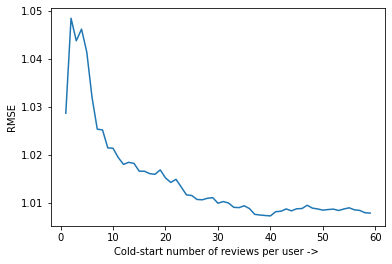

In [60]:
import matplotlib.pyplot as plt
x_axis = np.array(range(1, 60))
y_axis = RMSE_values 
plt.plot(x_axis, y_axis[1:])  # Plot the chart
plt.xlabel("Cold-start number of reviews per user -> ")
plt.ylabel("RMSE")
plt.show()  # display


In [31]:
## convert your array into a dataframe
df = pd.DataFrame(RMSE_values)

## save to xlsx file

filepath = 'RMSE_PIP_1M.xlsx'

df.to_excel(filepath, index=False)

In [73]:
X_train['user_id'].unique().shape

(943,)

85709    876
47085    379
40294     58
95455    846
8396     289
        ... 
39395    255
73462    892
47996    655
9520     239
89580    632
Name: user_id, Length: 25000, dtype: int64